<a href="https://colab.research.google.com/github/oreilly-japan/ml-at-work/blob/master/chap10/LR-forbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-947-2.gif)

이 노트북은 한빛미디어에서 발생한 [<<머신러닝 실무 프로젝트 2판>>]()의 샘플 코드입니다. 코드 설명은 책 내용을 확인합니다. 또한, 이 코드를 실행한 결과에 대해 한빛미디어 및 옮긴이는 일체의 책임을 지지 않습니다.

In [1]:
# 이 셀은 한글 폰트 설치시에만 실행하며,
# 실행 후 런타임을 다시 시작합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,360 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155229 files and d

In [1]:
import random

def generate_sample_data(num, seed=1):
    is_cv_list = []
    is_treat_list = []
    feature_vector_list = []

    random_instance = random.Random(seed)

    feature_num = 8
    base_weight = [0.02, 0.03, 0.05, -0.04, 0.00, 0.00, 0.00, 0.00]
    lift_weight = [0.00, 0.00, 0.00, 0.05, -0.05, 0.00, 0.00, 0.00]

    for i in range(num):
        feature_vector = [random_instance.random() for n in range(feature_num)]
        is_treat = random_instance.choice((True, False))
        cv_rate = sum([feature_vector[n] * base_weight[n] for n in range(feature_num)])

        if is_treat:
            cv_rate += sum([feature_vector[n] * lift_weight[n] for n in range(feature_num)])

        is_cv = cv_rate > random_instance.random()

        is_cv_list.append(is_cv)
        is_treat_list.append(is_treat)
        feature_vector_list.append(feature_vector)

    return is_cv_list, is_treat_list, feature_vector_list


In [2]:
generate_sample_data(2)

([False, False],
 [True, True],
 [[0.13436424411240122,
   0.8474337369372327,
   0.763774618976614,
   0.2550690257394217,
   0.49543508709194095,
   0.4494910647887381,
   0.651592972722763,
   0.7887233511355132],
  [0.8933170425576351,
   0.3898088070211341,
   0.6074379962852603,
   0.767157629147962,
   0.6958328667684435,
   0.26633056045725956,
   0.8018263669964836,
   0.5911534350013039]])

In [3]:

from sklearn.linear_model import LogisticRegression

# train 데이터 생성
sample_num = 100000
train_is_cv_list, train_is_treat_list, train_feature_vector_list = generate_sample_data(sample_num, seed=1)

# 학습기 생성
treat_model = LogisticRegression(C=0.01)
control_model = LogisticRegression(C=0.01)

# 데이터를 treatment와 control로 분리
treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(train_feature_vector_list[i])
    else:
        control_is_cv_list.append(train_is_cv_list[i])
        control_feature_vector_list.append(train_feature_vector_list[i])

# 학습기 구현
treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01)

In [4]:
print("treatment_cvr", treat_is_cv_list.count(True) / len(treat_is_cv_list))
print("control_cvr", control_is_cv_list.count(True) / len(control_is_cv_list))


treatment_cvr 0.031220247540463344
control_cvr 0.031905453372055505


In [5]:
treat_model.coef_

array([[ 0.30104024,  0.46851617,  0.78184764,  0.12162832, -0.96183274,
         0.04103385, -0.02722078, -0.01957698]])

In [6]:
control_model.coef_

array([[ 0.34221212,  0.55829557,  0.80051067, -0.78362251,  0.01301212,
        -0.01596908, -0.03519542, -0.00425632]])

In [7]:
# 난수 시드를 바꿔 테스트 데이터 생성
test_is_cv_list, test_is_treat_list, test_feature_vector_list = generate_sample_data(sample_num, seed=42)

# 각 학습기별로 전환율 예측
treat_score = treat_model.predict_proba(test_feature_vector_list)
control_score = control_model.predict_proba(test_feature_vector_list)

# 점수를 계산한다(실험군 에측 전환율 / 대조군 예측 전환율)
# predict_proba는 각 클래스에 속할 확률의 리스트를 반환하므로 첫 번째 값만 확인한다.
# 반환값이 numpy.ndarray 타입이므로 그대로 나눠도 요소 단위 나눗셈이 된다.
score_list = treat_score[:,1] / control_score[:,1]

In [8]:
%config InlineBackend.figure_formats = {'png', 'retina'}

Text(0, 0.5, '전환율')

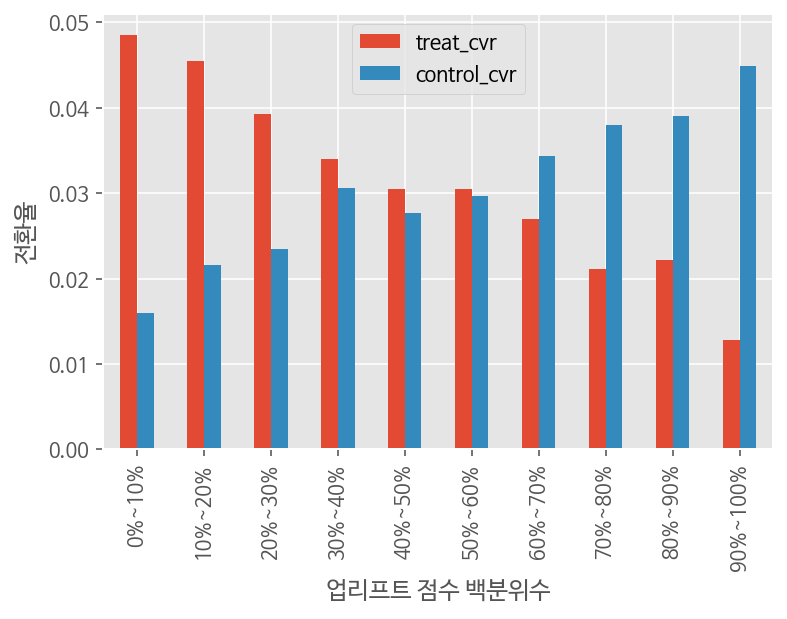

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
plt.style.use('ggplot')
plt.rc('font', family='NanumBarunGothic')

%matplotlib inline 

# 점수가 높은 순서대로 정렬
result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    # 결과를 10% 단위로 나눈다
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]

    # 실험군과 대조군에서 결과 집계
    treat_uu = list(
        map(lambda item:item[1], quantiled_result)).count(True)
    control_uu = list(
        map(lambda item:item[1], quantiled_result)).count(False)

    # 실험군과 대조군에서 전환 건수 집계
    treat_cv = [item[0] for item in quantiled_result 
                if item[1] == True].count(True)
    control_cv = [item[0] for item in quantiled_result 
                  if item[1] == False].count(True)

    # 전환 건숭서 전환율을 계산해 DataFrame에 저장
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    label = "{}%~{}%".format(n*10, (n+1)*10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel("업리프트 점수 백분위수")
plt.ylabel("전환율")

Text(0, 0.5, '전환 리프트')

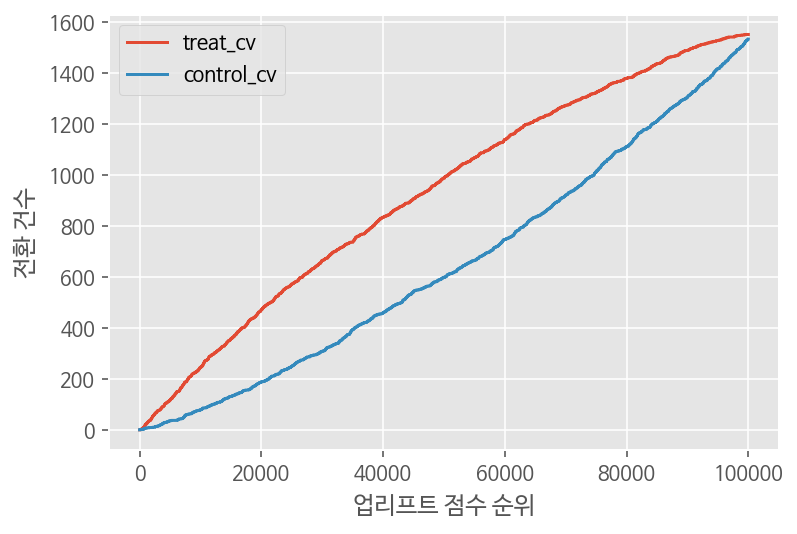

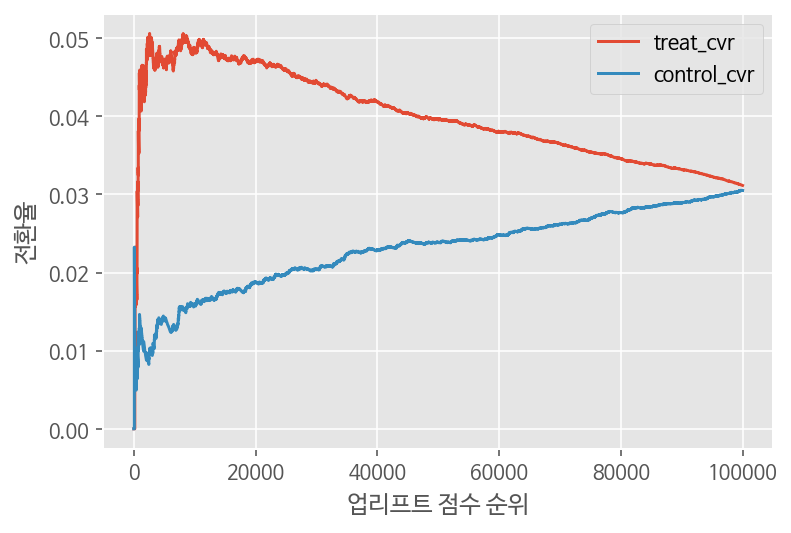

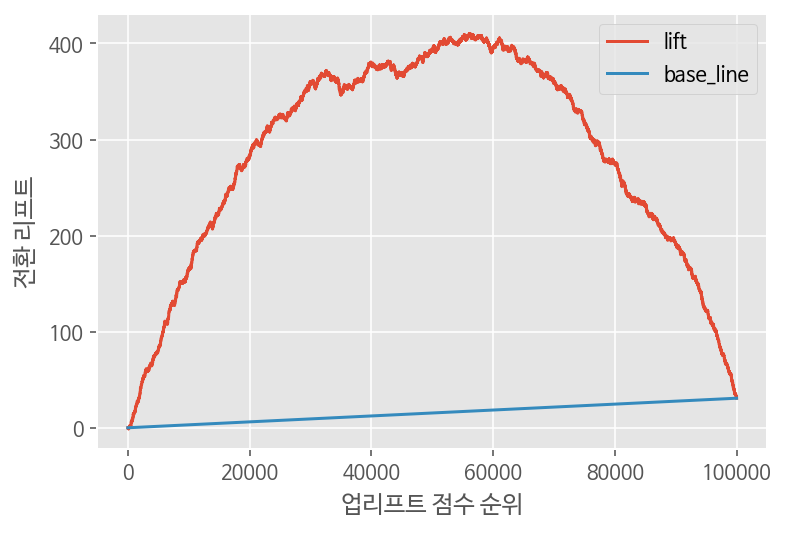

In [10]:
# 점수 순으로 집계
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu

    # 전환율의 차와 실험군의 사람 수를 곱해서 lift를 산출
    lift = (treat_cvr - control_cvr) * treat_uu

    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])

# 통계 데이터를 DataFrame으로 변환
df = pd.DataFrame(stat_data)
df.columns = ["is_cv", "is_treat", "score", "treat_uu", "control_uu", "treat_cv", "control_cv", "treat_cvr", "control_cvr", "lift"]

# 베이스라인 추가
df["base_line"] = df.index * df["lift"][len(df.index) - 1] / len(df.index)

# 시각화
df.plot(y=["treat_cv", "control_cv"])
plt.xlabel("업리프트 점수 순위")
plt.ylabel("전환 건수")

df.plot(y=["treat_cvr", "control_cvr"])
plt.xlabel("업리프트 점수 순위")
plt.ylabel("전환율")


df.plot(y=["lift", "base_line"])
plt.xlabel("업리프트 점수 순위")
plt.ylabel("전환 리프트")


Text(0, 0.5, '전환 리프트')

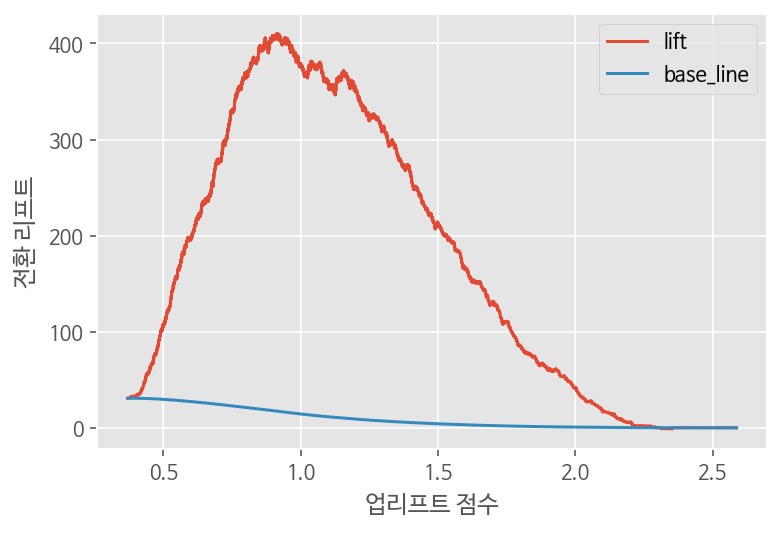

In [11]:
# df.plot(x="score", y=["treat_cv", "control_cv"], title="conversion count")
# df.plot(x="score", y=["treat_cvr", "control_cvr"], title="conversion rate")
df.plot(x="score", y=["lift", "base_line"])
plt.xlabel("업리프트 점수")
plt.ylabel("전환 리프트")


In [12]:
auuc = (df["lift"] - df["base_line"]).sum() / len(df["lift"])
print("AUUC:", auuc)

AUUC: 267.03766473645675
